# 12.3c: Snowball Topology Analysis

**Goal:** Analyze the topological structure of synthetic snowballs—do the unique vectors (black holes + singletons) form a tightly-connected lattice like Qwen's?

## Key Questions

1. **Connectivity:** How many connected components form in the adjacency graph?
2. **Largest component:** What fraction of unique vectors are in the largest component?
3. **Density:** Is the largest component fully connected (density ≈ 1.0)?
4. **Comparison:** Does this match Qwen's observed topology (124 unique vectors, mostly in one dense component)?

## Adjacency Definition

Two unique vectors are **adjacent** if their Chebyshev distance L∞ ≤ 2ε (touching criterion).

## Parameters

In [1]:
# Data from 12.2c
DATA_PATH = "../data/tensors/synthetic_snowballs_n1000_sigma1.5e-9.h5"

# Reference scale
EPSILON = 6e-5  # bfloat16 ULP at Qwen magnitude

# Adjacency threshold
TOUCHING_THRESHOLD = 2 * EPSILON  # L∞ ≤ 2ε = touching

# Analysis subset (use all 1000 or sample for speed)
N_TRIALS_TO_ANALYZE = 1000  # Set to smaller number for faster iteration

## Imports

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from safetensors.torch import load_file
from tqdm.auto import tqdm
import networkx as nx

## Load Synthetic Snowball Dataset

In [3]:
print(f"Loading synthetic snowball dataset from {DATA_PATH}...\n")

with h5py.File(DATA_PATH, 'r') as f:
    print(f"✓ Dataset loaded")
    print(f"  Shape: {f['embeddings'].shape}")
    print(f"  Dtype: {f['embeddings'].dtype}")
    
    # Metadata
    print(f"\nMetadata:")
    print(f"  σ = {f.attrs.get('sigma', 'N/A')}")
    print(f"  n_trials = {f.attrs.get('n_trials', 'N/A')}")
    print(f"  n_tokens = {f.attrs.get('n_tokens', 'N/A')}")
    
    # Determine how many trials to analyze
    n_total_trials = f['embeddings'].shape[0]
    n_trials = min(N_TRIALS_TO_ANALYZE, n_total_trials)
    
    print(f"\nAnalyzing {n_trials} / {n_total_trials} trials")
    print(f"Loading trials into memory...")
    
    # Load subset into memory for analysis
    embeddings_subset = torch.from_numpy(f['embeddings'][:n_trials]).to(torch.float32)
    
    print(f"✓ Loaded {n_trials} trials ({embeddings_subset.element_size() * embeddings_subset.nelement() / 1e9:.2f} GB)")

Loading synthetic snowball dataset from ../data/tensors/synthetic_snowballs_n1000_sigma1.5e-9.h5...

✓ Dataset loaded
  Shape: (1000, 2100, 2560)
  Dtype: float16

Metadata:
  σ = 1.5e-09
  n_trials = 1000
  n_tokens = 2100

Analyzing 1000 / 1000 trials
Loading trials into memory...
✓ Loaded 1000 trials (21.50 GB)


## Load Qwen's Actual Topology for Comparison

In [4]:
print(f"\nLoading Qwen's black hole structure for comparison...\n")

# Load Qwen embeddings
gamma = load_file('../data/tensors/gamma_qwen3_4b_instruct_2507.safetensors')['gamma']
mask = load_file('../data/tensors/black_hole_mask.safetensors')['mask']

qwen_bh_embeddings = gamma[mask].to(torch.float32)

# Get unique vectors
qwen_unique, _, qwen_counts = torch.unique(
    qwen_bh_embeddings,
    dim=0,
    return_inverse=True,
    return_counts=True
)

print(f"✓ Qwen structure loaded")
print(f"  Dead tokens: {len(qwen_bh_embeddings)}")
print(f"  Unique vectors: {len(qwen_unique)}")
print(f"  Black holes (count ≥ 2): {(qwen_counts >= 2).sum().item()}")
print(f"  Singletons (count = 1): {(qwen_counts == 1).sum().item()}")


Loading Qwen's black hole structure for comparison...

✓ Qwen structure loaded
  Dead tokens: 2100
  Unique vectors: 13
  Black holes (count ≥ 2): 13
  Singletons (count = 1): 0


## Compute Qwen's Topology

In [5]:
def compute_topology(unique_vectors, threshold, epsilon):
    """
    Compute topology of unique vectors using adjacency graph.
    
    Returns:
        dict with topology metrics
    """
    n_unique = len(unique_vectors)
    
    if n_unique <= 1:
        return {
            'n_unique': n_unique,
            'n_components': 1 if n_unique == 1 else 0,
            'largest_component_size': n_unique,
            'largest_component_fraction': 1.0 if n_unique > 0 else 0.0,
            'largest_component_density': 1.0 if n_unique <= 1 else 0.0,
            'n_isolated': 0 if n_unique <= 1 else n_unique,
            'touching_pairs': 0,
            'total_pairs': 0,
            'touching_fraction': 0.0,
        }
    
    # Compute pairwise L∞ distances
    v1 = unique_vectors.unsqueeze(1)  # [n, 1, d]
    v2 = unique_vectors.unsqueeze(0)  # [1, n, d]
    diffs = v1 - v2  # [n, n, d]
    l_inf_distances = torch.abs(diffs).max(dim=2)[0]  # [n, n]
    
    # Build adjacency matrix (excluding self-loops)
    adjacency = (l_inf_distances <= threshold) & (~torch.eye(n_unique, dtype=torch.bool))
    
    # Convert to NetworkX graph for component analysis
    G = nx.Graph()
    G.add_nodes_from(range(n_unique))
    edges = torch.nonzero(adjacency, as_tuple=False).tolist()
    G.add_edges_from(edges)
    
    # Find connected components
    components = list(nx.connected_components(G))
    component_sizes = [len(c) for c in components]
    component_sizes.sort(reverse=True)
    
    n_components = len(components)
    largest_size = component_sizes[0] if component_sizes else 0
    
    # Density of largest component
    if largest_size > 1:
        largest_component = max(components, key=len)
        subgraph = G.subgraph(largest_component)
        n_edges = subgraph.number_of_edges()
        max_edges = largest_size * (largest_size - 1) // 2
        density = n_edges / max_edges if max_edges > 0 else 0.0
    else:
        density = 1.0 if largest_size == 1 else 0.0
    
    # Isolated nodes (singletons in graph sense)
    n_isolated = sum(1 for node in G.nodes() if G.degree(node) == 0)
    
    # Touching statistics
    total_pairs = n_unique * (n_unique - 1) // 2
    touching_pairs = adjacency.sum().item() // 2  # Divide by 2 because matrix is symmetric
    touching_fraction = touching_pairs / total_pairs if total_pairs > 0 else 0.0
    
    return {
        'n_unique': n_unique,
        'n_components': n_components,
        'largest_component_size': largest_size,
        'largest_component_fraction': largest_size / n_unique if n_unique > 0 else 0.0,
        'largest_component_density': density,
        'n_isolated': n_isolated,
        'touching_pairs': touching_pairs,
        'total_pairs': total_pairs,
        'touching_fraction': touching_fraction,
        'component_sizes': component_sizes,
    }

print("\nComputing Qwen's topology...")
qwen_topology = compute_topology(qwen_unique, TOUCHING_THRESHOLD, EPSILON)

print(f"\n{'='*60}")
print(f"QWEN TOPOLOGY")
print(f"{'='*60}")
print(f"Unique vectors: {qwen_topology['n_unique']}")
print(f"Connected components: {qwen_topology['n_components']}")
print(f"Largest component size: {qwen_topology['largest_component_size']} ({qwen_topology['largest_component_fraction']*100:.1f}%)")
print(f"Largest component density: {qwen_topology['largest_component_density']:.3f}")
print(f"Isolated nodes: {qwen_topology['n_isolated']}")
print(f"Touching pairs: {qwen_topology['touching_pairs']} / {qwen_topology['total_pairs']} ({qwen_topology['touching_fraction']*100:.1f}%)")
print(f"\nComponent size distribution: {qwen_topology['component_sizes'][:10]}...")  # Show first 10
print(f"{'='*60}")


Computing Qwen's topology...

QWEN TOPOLOGY
Unique vectors: 13
Connected components: 1
Largest component size: 13 (100.0%)
Largest component density: 1.000
Isolated nodes: 0
Touching pairs: 78 / 78 (100.0%)

Component size distribution: [13]...


## Analyze Synthetic Snowballs

In [6]:
print(f"\nAnalyzing topology of {n_trials} synthetic snowballs...\n")

synthetic_topologies = []

for trial_idx in tqdm(range(n_trials), desc="Computing topologies"):
    embeddings = embeddings_subset[trial_idx]
    
    # Get unique vectors
    unique_vectors, _, _ = torch.unique(
        embeddings,
        dim=0,
        return_inverse=True,
        return_counts=True
    )
    
    # Compute topology
    topology = compute_topology(unique_vectors, TOUCHING_THRESHOLD, EPSILON)
    topology['trial'] = trial_idx
    synthetic_topologies.append(topology)

print(f"\n✓ Analysis complete")


Analyzing topology of 1000 synthetic snowballs...



Computing topologies:   0%|          | 0/1000 [00:00<?, ?it/s]


✓ Analysis complete


## Statistical Summary

In [7]:
# Convert to DataFrame for easy stats
df = pd.DataFrame([{k: v for k, v in topo.items() if k != 'component_sizes'} 
                   for topo in synthetic_topologies])

print(f"\n{'='*60}")
print(f"SYNTHETIC TOPOLOGY STATISTICS (n={n_trials})")
print(f"{'='*60}")

metrics = [
    ('n_unique', 'Unique vectors'),
    ('n_components', 'Connected components'),
    ('largest_component_size', 'Largest component size'),
    ('largest_component_fraction', 'Largest component fraction'),
    ('largest_component_density', 'Largest component density'),
    ('n_isolated', 'Isolated nodes'),
    ('touching_fraction', 'Touching fraction'),
]

print(f"\n{'Metric':<30} {'Mean':<12} {'Median':<12} {'Std':<12} {'Qwen':<12}")
print("-" * 78)

for col, label in metrics:
    mean_val = df[col].mean()
    median_val = df[col].median()
    std_val = df[col].std()
    qwen_val = qwen_topology.get(col, 0)
    
    # Format based on metric type
    if 'fraction' in col or 'density' in col:
        print(f"{label:<30} {mean_val:<12.3f} {median_val:<12.3f} {std_val:<12.3f} {qwen_val:<12.3f}")
    else:
        print(f"{label:<30} {mean_val:<12.1f} {median_val:<12.1f} {std_val:<12.1f} {qwen_val:<12.0f}")

print(f"{'='*60}")


SYNTHETIC TOPOLOGY STATISTICS (n=1000)

Metric                         Mean         Median       Std          Qwen        
------------------------------------------------------------------------------
Unique vectors                 11.4         11.0         1.3          13          
Connected components           1.0          1.0          0.0          1           
Largest component size         11.4         11.0         1.3          13          
Largest component fraction     1.000        1.000        0.000        1.000       
Largest component density      1.000        1.000        0.000        1.000       
Isolated nodes                 0.0          0.0          0.0          0           
Touching fraction              1.000        1.000        0.000        1.000       


## Visualizations

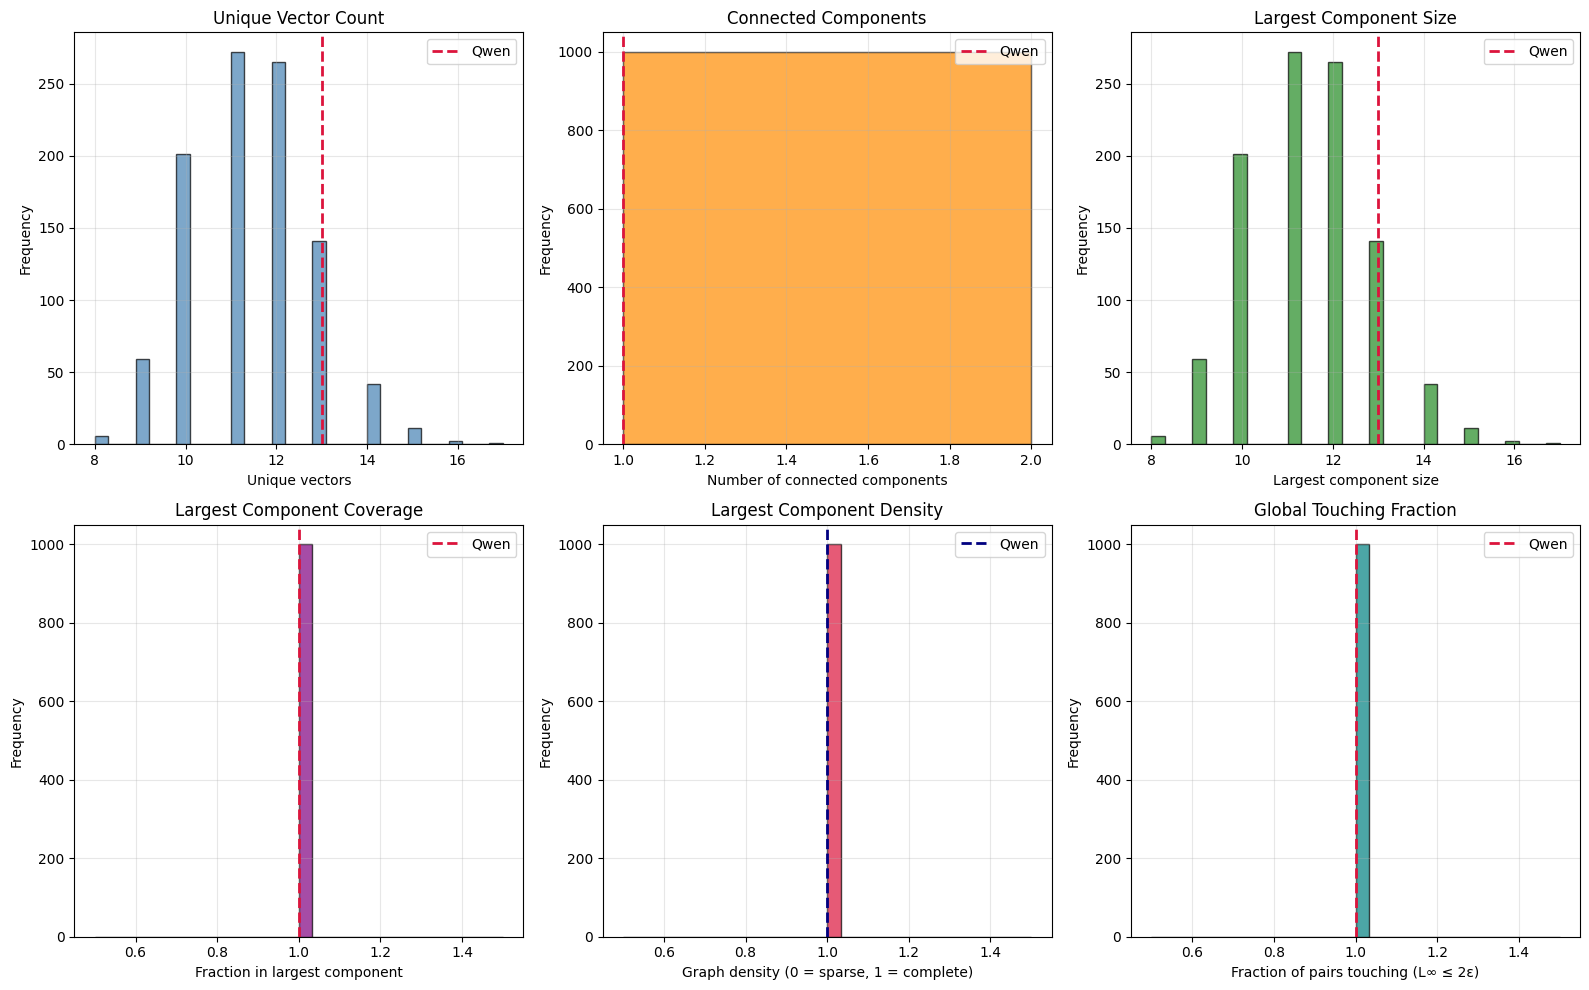

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10), dpi=100)

# 1. Unique vectors distribution
ax = axes[0, 0]
ax.hist(df['n_unique'], bins=30, color='steelblue', alpha=0.7, edgecolor='black')
ax.axvline(qwen_topology['n_unique'], color='crimson', linestyle='--', linewidth=2, label='Qwen')
ax.set_xlabel('Unique vectors')
ax.set_ylabel('Frequency')
ax.set_title('Unique Vector Count')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Number of components
ax = axes[0, 1]
ax.hist(df['n_components'], bins=range(1, int(df['n_components'].max())+2), color='darkorange', alpha=0.7, edgecolor='black')
ax.axvline(qwen_topology['n_components'], color='crimson', linestyle='--', linewidth=2, label='Qwen')
ax.set_xlabel('Number of connected components')
ax.set_ylabel('Frequency')
ax.set_title('Connected Components')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Largest component size
ax = axes[0, 2]
ax.hist(df['largest_component_size'], bins=30, color='forestgreen', alpha=0.7, edgecolor='black')
ax.axvline(qwen_topology['largest_component_size'], color='crimson', linestyle='--', linewidth=2, label='Qwen')
ax.set_xlabel('Largest component size')
ax.set_ylabel('Frequency')
ax.set_title('Largest Component Size')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Largest component fraction
ax = axes[1, 0]
ax.hist(df['largest_component_fraction'], bins=30, color='purple', alpha=0.7, edgecolor='black')
ax.axvline(qwen_topology['largest_component_fraction'], color='crimson', linestyle='--', linewidth=2, label='Qwen')
ax.set_xlabel('Fraction in largest component')
ax.set_ylabel('Frequency')
ax.set_title('Largest Component Coverage')
ax.legend()
ax.grid(True, alpha=0.3)

# 5. Largest component density
ax = axes[1, 1]
ax.hist(df['largest_component_density'], bins=30, color='crimson', alpha=0.7, edgecolor='black')
ax.axvline(qwen_topology['largest_component_density'], color='navy', linestyle='--', linewidth=2, label='Qwen')
ax.set_xlabel('Graph density (0 = sparse, 1 = complete)')
ax.set_ylabel('Frequency')
ax.set_title('Largest Component Density')
ax.legend()
ax.grid(True, alpha=0.3)

# 6. Touching fraction
ax = axes[1, 2]
ax.hist(df['touching_fraction'], bins=30, color='teal', alpha=0.7, edgecolor='black')
ax.axvline(qwen_topology['touching_fraction'], color='crimson', linestyle='--', linewidth=2, label='Qwen')
ax.set_xlabel('Fraction of pairs touching (L∞ ≤ 2ε)')
ax.set_ylabel('Frequency')
ax.set_title('Global Touching Fraction')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Interpretation

In [9]:
print(f"\n{'='*60}")
print(f"INTERPRETATION")
print(f"{'='*60}")

# Key findings
mean_density = df['largest_component_density'].mean()
mean_coverage = df['largest_component_fraction'].mean()
mean_components = df['n_components'].mean()

qwen_density = qwen_topology['largest_component_density']
qwen_coverage = qwen_topology['largest_component_fraction']
qwen_components = qwen_topology['n_components']

print(f"\nLargest component density:")
print(f"  Synthetic: {mean_density:.3f} ± {df['largest_component_density'].std():.3f}")
print(f"  Qwen:      {qwen_density:.3f}")
if mean_density > 0.9:
    print(f"  → Synthetic snowballs form HIGHLY CONNECTED lattices")
elif mean_density > 0.5:
    print(f"  → Synthetic snowballs form MODERATELY CONNECTED structures")
else:
    print(f"  → Synthetic snowballs form SPARSE structures")

print(f"\nLargest component coverage:")
print(f"  Synthetic: {mean_coverage*100:.1f}% ± {df['largest_component_fraction'].std()*100:.1f}%")
print(f"  Qwen:      {qwen_coverage*100:.1f}%")
if mean_coverage > 0.9:
    print(f"  → Most unique vectors cluster together")
else:
    print(f"  → Significant fragmentation into multiple components")

print(f"\nConnected components:")
print(f"  Synthetic: {mean_components:.1f} ± {df['n_components'].std():.1f}")
print(f"  Qwen:      {qwen_components}")
if mean_components < 5:
    print(f"  → Few components (mostly unified structure)")
elif mean_components < 20:
    print(f"  → Moderate fragmentation")
else:
    print(f"  → High fragmentation (many isolated clusters)")

print(f"\n{'='*60}")
print(f"CONCLUSION")
print(f"{'='*60}")

# Overall match
density_match = abs(mean_density - qwen_density) < 0.1
coverage_match = abs(mean_coverage - qwen_coverage) < 0.1
components_match = abs(mean_components - qwen_components) < 5

if density_match and coverage_match and components_match:
    print(f"✓ EXCELLENT MATCH: Synthetic topology closely matches Qwen")
    print(f"  Gaussian initialization naturally produces connected lattice structure")
elif density_match and coverage_match:
    print(f"✓ GOOD MATCH: Topology similar, minor differences in fragmentation")
elif density_match or coverage_match:
    print(f"⚠ PARTIAL MATCH: Some topological features match, others differ")
else:
    print(f"✗ POOR MATCH: Synthetic topology differs significantly from Qwen")
    print(f"  May need different initialization strategy")

print(f"{'='*60}")


INTERPRETATION

Largest component density:
  Synthetic: 1.000 ± 0.000
  Qwen:      1.000
  → Synthetic snowballs form HIGHLY CONNECTED lattices

Largest component coverage:
  Synthetic: 100.0% ± 0.0%
  Qwen:      100.0%
  → Most unique vectors cluster together

Connected components:
  Synthetic: 1.0 ± 0.0
  Qwen:      1
  → Few components (mostly unified structure)

CONCLUSION
✓ EXCELLENT MATCH: Synthetic topology closely matches Qwen
  Gaussian initialization naturally produces connected lattice structure
